In [1]:
import json
import numpy as np
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
import torch
import time


class MyDynamicDatasetLoader(object):
    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        with open('data/graphs/grafo_corr_sliding.json') as f:
            self._dataset = json.load(f)

    def _get_edges(self):
        self._edges = []
        for time in self._dataset["time_periods"]:
            self._edges.append(
                np.array(self._dataset["edge_mapping"]["edge_index"][str(time)]).T
            )
        self._edges = self._edges[self.lags-1:]

    def _get_node_ids(self):
        self._node_ids = np.array(self._dataset["node_ids"])
    
    def _get_edge_weights(self):
        self._edge_weights = []
        for time in self._dataset["time_periods"]:
            self._edge_weights.append(
                np.array(self._dataset["edge_mapping"]["edge_weight"][str(time)])
            )
        self._edge_weights = self._edge_weights[self.lags-1:]

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["y"])
        self.scale = []
        for i in range(24):
            self.scale.append(max(stacked_target[:,i]))
        self.scale = np.array(self.scale)
        self.mu = np.mean(stacked_target, axis=0)
        self.sigma = np.std(stacked_target, axis=0)
        #standardized_target = (stacked_target - self.mu) / (self.sigma + 10 ** -10)
        standardized_target = stacked_target/self.scale
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"])-self.lags+1)
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"])-self.lags+1)
        ]

    def get_dataset(self, lags: int = 4) -> DynamicGraphTemporalSignal:
        """Returning the Wind Speed data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Wind Speed dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_node_ids()
        self._get_targets_and_features()
        dataset = DynamicGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset


In [50]:
lags = 3
out_channels1 = 20
out_channels2 = 25
loader = MyDynamicDatasetLoader()
dataset = loader.get_dataset(lags=lags)
dataset[1]

Data(x=[24, 3], edge_index=[2, 342], edge_attr=[342], y=[24])

In [51]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch_geometric_temporal.nn.recurrent import GConvGRU, TGCN, GConvLSTM
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [52]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent1 = TGCN(in_channels=node_features, out_channels=out_channels1, add_self_loops=False)
        self.recurrent2 = GConvLSTM(in_channels=out_channels1, out_channels=out_channels2, K=4)
        self.linear1 = torch.nn.Linear(out_channels2, 10)
        self.linear2 = torch.nn.Linear(10,1)
        self.dropout1 = torch.nn.Dropout(0.4)

    def forward(self, x, edge_index, edge_weight, H1, H2):
        H1 = self.recurrent1(x, edge_index, edge_weight, H1)
        H1 = self.dropout1(H1)
        H2,_ = self.recurrent2(H1, edge_index, edge_weight, H2)
        h = H2
        #h = self.dropout1(h)
        h = F.relu(h)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        return h,H1,H2

In [56]:
model = RecurrentGCN(node_features = lags)
name_model = model.recurrent1.__class__.__name__
name_model

'TGCN'

In [54]:
sigma = loader.sigma
mu = loader.mu
scale = loader.scale
def descale(output, sigma, mu, scale):
    return output*scale#*sigma + m

  Epoch 1/100
Training loss:  0.19703752
  Epoch 2/100
Training loss:  0.1539274
  Epoch 3/100
Training loss:  0.12563571
  Epoch 4/100
Training loss:  0.10291479
  Epoch 5/100
Training loss:  0.08372194
  Epoch 6/100
Training loss:  0.06735371
  Epoch 7/100
Training loss:  0.053488135
  Epoch 8/100
Training loss:  0.04134037
  Epoch 9/100
Training loss:  0.031745803
  Epoch 10/100
Training loss:  0.024558432
  Epoch 11/100
Training loss:  0.019147383
  Epoch 12/100
Training loss:  0.015482107
  Epoch 13/100
Training loss:  0.013279532
  Epoch 14/100
Training loss:  0.012264689
  Epoch 15/100
Training loss:  0.01206356
  Epoch 16/100
Training loss:  0.012389152
  Epoch 17/100
Training loss:  0.012961216
  Epoch 18/100
Training loss:  0.0135426065
  Epoch 19/100
Training loss:  0.014048007
  Epoch 20/100
Training loss:  0.014348499
  Epoch 21/100
Training loss:  0.014383348
  Epoch 22/100
Training loss:  0.014193768
  Epoch 23/100
Training loss:  0.013877264
  Epoch 24/100
Training loss

Text(0.5, 0, 'epoch')

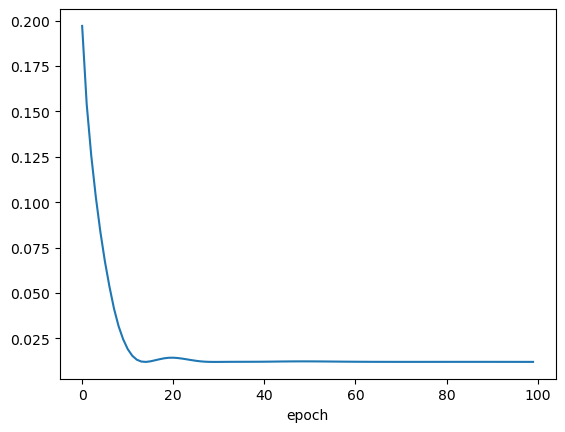

In [57]:
#model = model.to('cuda')
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.017, weight_decay=0.05)
loss_fn = F.mse_loss

start_time = time.perf_counter() # Start timer
num_epochs = 100
losses = []
outputs = []  #
targets = []  #
for epoch in range(num_epochs):
    loss = 0
    epoch_outputs = []  #
    epoch_targets = []  #
    H1 = torch.zeros(24,out_channels1)
    H2 = torch.zeros(24,out_channels2)
    print("  Epoch %d/%d" % (epoch+1,num_epochs))
    for time_step, snapshot in enumerate(train_dataset):
        #snapshot.to('cuda')
        output, H1, H2 = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H1=H1, H2=H2)
        loss = loss + loss_fn(output.T[0], snapshot.y)
        epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale))  #
        epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale))   #

    loss = loss/(time_step+1)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.cpu().detach().numpy())
    outputs.append(epoch_outputs)  #
    targets.append(epoch_targets)  #
    print('Training loss: ', losses[-1])

end_time = time.perf_counter() # End timer
print("Elapsed time: ", end_time - start_time) # Calculate elapsed time

plt.plot(losses)
plt.xlabel("epoch")

In [ ]:
#plt.plot(losses)

In [ ]:
# a=model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
# print(a)

In [ ]:
# print(epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)))
# print(epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)))

In [58]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[-1][i][j] for i in range(len(outputs[-1]))]
    tarhourlist = [targets[-1][i][j] for i in range(len(outputs[-1]))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)

In [59]:
#Test set
test_outputs = []  #
test_targets = []  #
for time_step, snapshot in enumerate(test_dataset):
    #snapshot.to('cuda')
    output, H1, H2 = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H1=H1, H2=H2)
    test_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    test_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    test_outputs.append(test_output)  #
    test_targets.append(test_snapshot)   #
#snapshot.x


In [60]:
outputs_hourly_test = []
targets_hourly_test = []
for j in range(24):
    outhourlist = [test_outputs[i][j] for i in range(len(test_outputs))]
    tarhourlist = [test_targets[i][j] for i in range(len(test_outputs))]
    outputs_hourly_test.append(outhourlist)
    targets_hourly_test.append(tarhourlist)

In [61]:
mse_test = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mse_test.append(np.mean(sqdiff))
mse_test

[1751.378765995827,
 770.1134733626615,
 426.6459033163636,
 611.6239632610418,
 780.9684516549661,
 1582.9822507738352,
 4880.249227336066,
 7073.435406076171,
 8225.58345168591,
 10742.800305545086,
 14370.200761030444,
 15954.007118008223,
 14140.691134862145,
 18015.34406383708,
 18324.520173012246,
 19805.414329481922,
 27605.13840622029,
 32109.941484516377,
 21909.317149816725,
 15401.405476867369,
 9216.24647904325,
 4478.2197016987775,
 2644.3609425590653,
 2373.760281726387]

In [62]:
np.mean(mse_test)

10549.764529237009

In [63]:
mse_train = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mse_train.append(np.mean(sqdiff))
mse_train

[2003.0893215722426,
 1191.5211646977002,
 620.8922403281052,
 740.0373532088938,
 923.8536444916872,
 1270.024433423972,
 4406.052470241572,
 5561.315771431938,
 7401.544555227815,
 9777.39625088329,
 14667.170642364004,
 19899.275418177986,
 19874.73533197072,
 21809.096578870907,
 22759.04215697156,
 23238.506503922614,
 28037.9619699601,
 36316.51140769356,
 20765.328509005725,
 15225.735653171136,
 11642.803566149689,
 9905.563921235362,
 3054.616470185464,
 2704.494292781739]

In [41]:
np.mean(mse_train)

8355.755520243207

In [42]:
#unisco train e test
outputs_merged = [l1 + l2 for l1, l2 in zip(outputs_hourly, outputs_hourly_test)]
targets_merged = [l1 + l2 for l1, l2 in zip(targets_hourly, targets_hourly_test)]

In [43]:
list_ids = loader._node_ids
dict = list_ids.item()
inverse_dict = {value: key for key, value in dict.items()}
inverse_dict.get(0)

'00:00'

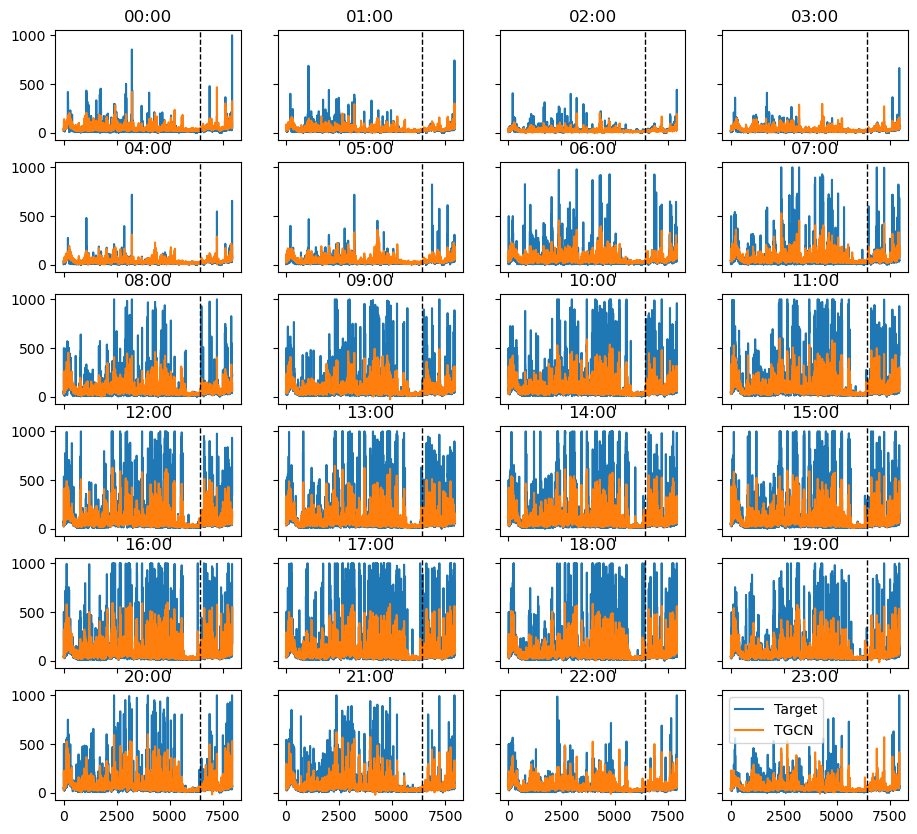

In [44]:
fig, axs = plt.subplots(6, 4, figsize=(11, 10), sharey=True, sharex=True)

# Iteriamo sulla lista delle matrici e le visualizziamo in subplots
for i in range(6):
    axs[i,0].plot(targets_merged[i*4], label="Target")
    axs[i,0].plot(outputs_merged[i*4], label=name_model)
    axs[i,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,1].plot(targets_merged[i*4+1], label="Target")
    axs[i,1].plot(outputs_merged[i*4+1], label=name_model)
    axs[i,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,2].plot(targets_merged[i*4+2], label="Target")
    axs[i,2].plot(outputs_merged[i*4+2], label=name_model)
    axs[i,2].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,3].plot(targets_merged[i*4+3], label="Target")
    axs[i,3].plot(outputs_merged[i*4+3], label=name_model)
    axs[i,3].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,0].set_title(inverse_dict[i*4])  # Titolo del subplot
    axs[i,1].set_title(inverse_dict[i*4+1])
    axs[i,2].set_title(inverse_dict[i*4+2])
    axs[i,3].set_title(inverse_dict[i*4+3])
    #axs[i].axis('off')  # Nasconde gli assi

plt.legend()
plt.savefig('plot/dyn'+name_model.lower()+'.jpg', format='jpg')
# Mostriamo la figura con tutti i subplot
plt.show()

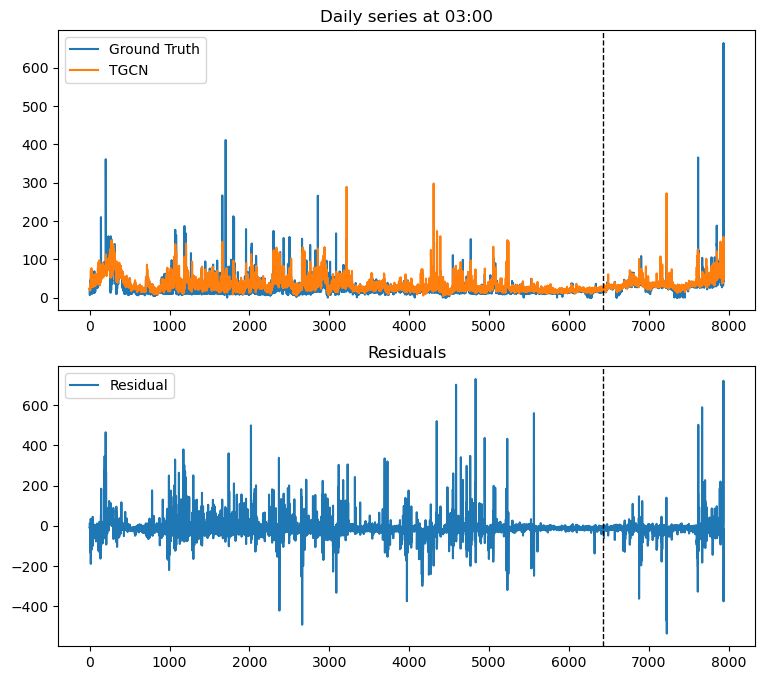

In [45]:
hour = 3

diff = [a - b for a, b in zip(targets_merged[j], outputs_merged[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_merged[hour], label="Ground Truth")
axs[0].plot(outputs_merged[hour], label=name_model)
axs[0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour])
axs[1].plot(diff, label="Residual")
axs[1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

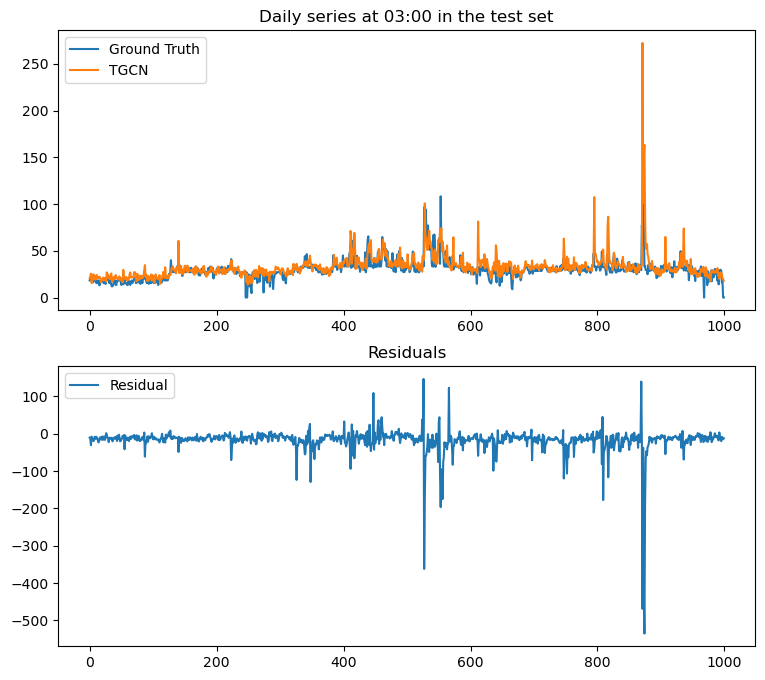

In [46]:
hour = 3

diff = [a - b for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_hourly_test[hour][:1000], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour][:1000], label=name_model)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour]+" in the test set")
axs[1].plot(diff[:1000], label="Residual")
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

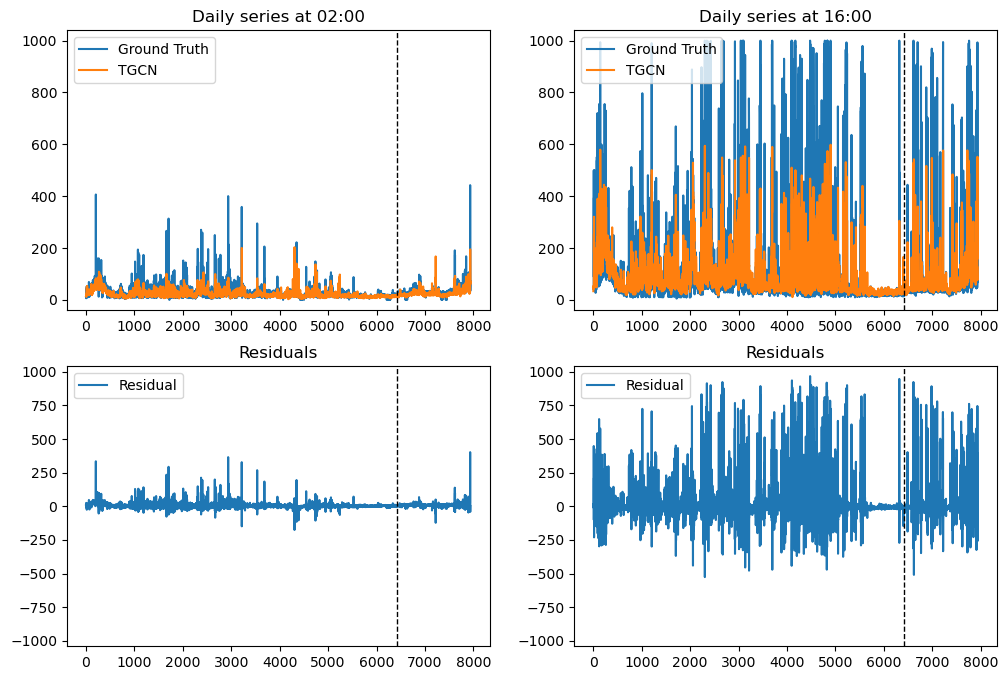

In [47]:
hour1 = 2
hour2 = 16

diff1 = [a - b for a, b in zip(targets_merged[hour1], outputs_merged[hour1])]
diff2 = [a - b for a, b in zip(targets_merged[hour2], outputs_merged[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_merged[hour1], label="Ground Truth")
axs[0,0].plot(outputs_merged[hour1], label=name_model)
axs[0,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,0].legend()
axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1])
axs[1,0].plot(diff1, label="Residual")
axs[1,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,0].legend()
axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_merged[hour2], label="Ground Truth")
axs[0,1].plot(outputs_merged[hour2], label=name_model)
axs[0,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,1].legend()
axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2])
axs[1,1].plot(diff2, label="Residual")
axs[1,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,1].legend()
axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focusdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

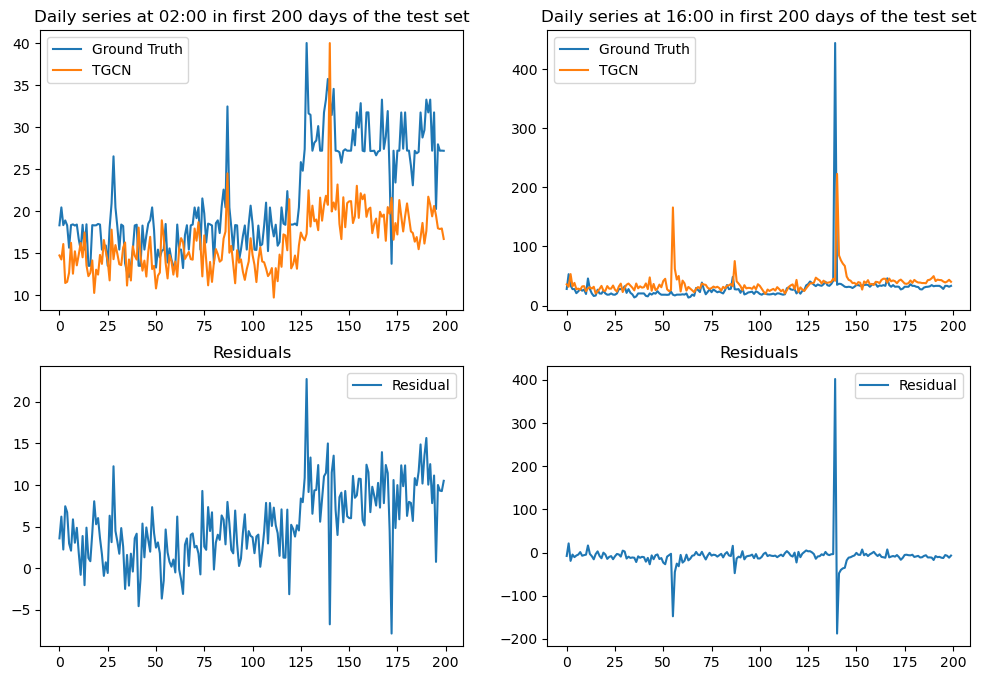

In [48]:
hour1 = 2
hour2 = 16
fd=200

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][:fd], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][:fd], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in first "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[:fd], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][:fd], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][:fd], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[:fd], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

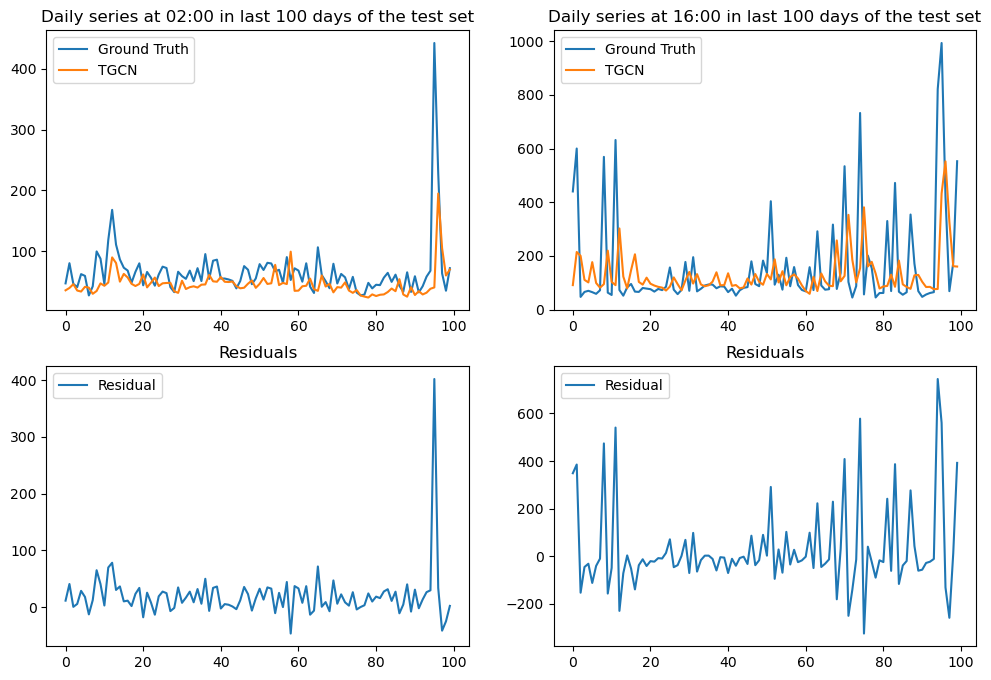

In [49]:
#o uno o l'altro
hour1 = 2
hour2 = 16
fd=100

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][-fd:], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][-fd:], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in last "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[-fd:], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][-fd:], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][-fd:], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in last "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[-fd:], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [143]:
# Per salvare modello
#model = model.to('cpu')
#torch.save(model.state_dict(), 'models/gnn_dyn2'+name_model+'_3_0.1.pth')


In [ ]:
# Per caricare modello
#model = RecurrentGCN(node_features = lags)
#model.load_state_dict(torch.load('models/gnn_dyn2'+name_model+'_3_0.1.pth'))
#model = model.to('cuda')
#print(model)